## RNN Train Script

Este es el archivo donde se hará una prueba de clasificador automático mediante CNN (Convolutional Neural Network).

De manera independiente se van a cargar las librerías necesarias para el script.
A la hora de realizar este script, Tensorflow/Keras no es aún compatible con Python 3.12, así que se usará la versión de Python 3.11.6

In [41]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.preprocessing import OneHotEncoder

Para puntualizar ahora mismo, se añadirán mas tipos en un futuro.
1. original_signals → Etiqueta 0.
2. flicker_signals → Etiqueta 1.
3. harmonic_signals → Etiqueta 2.
4. Interruption_signals → Etiqueta 3.
5. original_signals → Etiqueta 4.
6. Swell_signals → Etiqueta 5.
7. transient_signals → Etiqueta 6.

In [42]:
# Función para procesar señales
def preprocess_signal(signal):
    mean_value = np.mean(signal)
    unbias_data = signal - mean_value
    unbias_data_2 = unbias_data ** 2
    unbias_data_3 = unbias_data_2 * unbias_data
    unbias_data_4 = unbias_data_3 * unbias_data

    variance = np.var(unbias_data)
    skewness = np.mean(unbias_data_3) / (variance ** 1.5)
    kurtosis = np.mean(unbias_data_4) / (variance ** 2) - 3
    thd = np.sqrt(np.sum(np.abs(np.fft.fft(signal)[2:4])) / np.abs(np.fft.fft(signal)[1]))
    rms = np.sqrt(np.mean(signal ** 2))
    crest_factor = np.max(signal) / rms

    return np.array([variance, skewness, kurtosis, thd, crest_factor])

# Función para cargar señales y extraer características
def load_signal(data_path):
    label_mapping = {
        "flicker_signals": 0,
        "harmonic_signals": 1,
        "interruption_signals": 2,
        "original_signal": 3,
        "sag_signals": 4,
        "swell_signals": 5,
        "transient_signals": 6,
    }

    features = []
    labels = []

    for signal_type, label in label_mapping.items():
        signal_type_path = os.path.join(data_path, signal_type)
        if os.path.isdir(signal_type_path):
            for subset in ["train", "test", "val"]:
                subset_path = os.path.join(signal_type_path, subset)
                if os.path.exists(subset_path):
                    for filename in os.listdir(subset_path):
                        if filename.endswith(".npy"):
                            file_path = os.path.join(subset_path, filename)
                            signal = np.load(file_path)
                            feature_vector = preprocess_signal(signal)
                            features.append(feature_vector)
                            labels.append(label)

    return np.array(features), np.array(labels)

# Cargar datos
data_path = "data"  # Cambiar por la ruta adecuada
features, labels = load_signal(data_path)

In [43]:
# Dividir los datos
X_train, X_temp, y_train, y_temp = train_test_split(features, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Ajustar las dimensiones de los datos para el modelo LSTM
X_train = X_train[..., np.newaxis]  # Agregar una dimensión adicional
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# Confirmar las formas esperadas para LSTM: (batch_size, sequence_length, features)
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])  # (batch_size, sequence_length=1, features)
X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

print("Formas ajustadas para LSTM:")
print(f"X_train: {X_train.shape}, X_val: {X_val.shape}, X_test: {X_test.shape}")

# Convertir etiquetas a one-hot encoding si no están ya en ese formato
y_train_one_hot = to_categorical(y_train, num_classes=7)
y_val_one_hot = to_categorical(y_val, num_classes=7)
y_test_one_hot = to_categorical(y_test, num_classes=7)

# Modelo LSTM
model = Sequential([
    LSTM(128, activation='tanh', kernel_regularizer=l2(0.001), input_shape=(1, X_train.shape[2]), return_sequences=True),
    Dropout(0.3),
    LSTM(64, activation='tanh',return_sequences=True),
    Dropout(0.3),
    LSTM(64, activation='tanh',return_sequences=True),
    Dropout(0.3),
    LSTM(32, activation='tanh'),
    Dense(7, activation='softmax')  # Capa de salida para 7 clases
])

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(X_train, y_train_one_hot,
                    validation_data=(X_val, y_val_one_hot),
                    epochs=50,
                    batch_size=32)

# Evaluar el modelo
loss, accuracy = model.evaluate(X_test, y_test_one_hot)
print(f"Test Accuracy: {accuracy:.2f}")

# Predicciones
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_one_hot, axis=1)

# Matriz de confusión e informe de clasificación
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
print("Matriz de Confusión:\n", conf_matrix)

class_report = classification_report(y_test_classes, y_pred_classes)
print("Informe de Clasificación:\n", class_report)

Formas ajustadas para LSTM:
X_train: (17640, 1, 5), X_val: (3780, 1, 5), X_test: (3780, 1, 5)
Epoch 1/50


/Users/saguadog/Documents/TesisSergioAguado/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


552/552 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.2922 - loss: 1.8876 - val_accuracy: 0.2759 - val_loss: 1.6357
Epoch 2/50
552/552 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.2908 - loss: 1.6052 - val_accuracy: 0.2759 - val_loss: 1.5888
Epoch 3/50
552/552 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.2923 - loss: 1.5562 - val_accuracy: 0.2759 - val_loss: 1.5190
Epoch 4/50
552/552 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.3985 - loss: 1.4349 - val_accuracy: 0.4598 - val_loss: 1.2955
Epoch 5/50
552/552 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.4989 - loss: 1.2596 - val_accuracy: 0.5466 - val_loss: 1.1696
Epoch 6/50
552/552 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.5577 - loss: 1.1439 - val_accuracy: 0.5955 - val_loss: 1.0407
Epoch 7/50
552/552 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.5828 - loss: 1.0511 - val_accuracy: 0.6257 - val_loss: 0.9692
Epoch 8/50
552/552 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.6148 - loss: 0.9765 - val_accurac

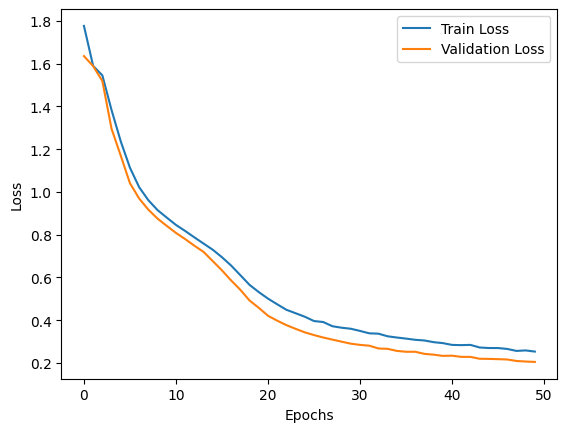

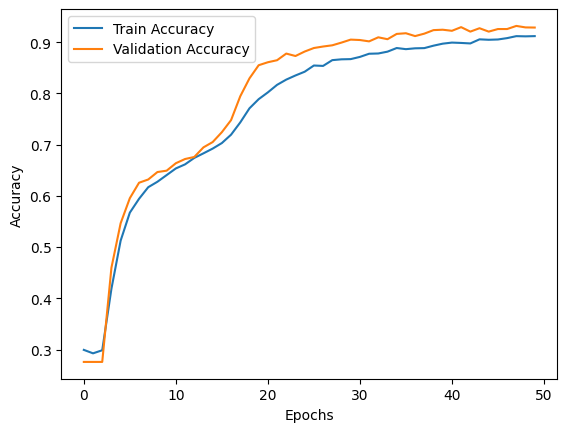

In [44]:
# Gráfico de pérdida
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Gráfico de precisión
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()